# LBM Step 1: Pre-Processing

## Steps:

**1a.** Set up filepaths.

**1b.** Extract ScanImage metadata.

**1c.** Use metadata to de-interleave frames into planar timeseries.

**1d.** Correct Bi-Directional Offset for each ROI.


In [1]:
## Imports
%load_ext autoreload
%autoreload 2

import os
import time
import logging
import sys
from pathlib import Path
import numpy as np
import napari
import pandas as pd
import tifffile

# Importing this WONT WORK withotu adding to the path
sys.path.append('../..')  # TODO: Take this out when we upload to pypi

import matplotlib.pyplot as plt

# MBO Repositories
import scanreader as sr
import lbm_caiman_python as lcp
import napari_lbm

pd.options.display.max_colwidth = 120

## Set up filepaths

For pre-processing, you generally need to hold 2 filepaths:

- input data: path to raw scanimage .tiff files
- output data: path to save the pre-processed datasets

*Note:* To avoid issues with forword vs backslash, Windows filepaths vs Linux filepaths, we recommend using the pythong builtin module [pathlib](https://docs.python.org/3/library/pathlib.html). Examples of its use can be seen throughout these examples, namely via [`pathlib.Path`](https://docs.python.org/3/library/pathlib.html#pure-paths).

### WSL ONLY

if you want

``` bash
C:\Users\john_doe\caiman_data 
```

instead of 

``` bash
home_path = Path(os.environ.get("HOME", Path().home()))
```

In [2]:
import os
print('These will be different if your python interpeter is on the wrong filesystem:')
print(f"Home Path (from env variable) : { Path( os.environ.get('HOME')) }")
print(f"Home Path (from pathlib)      : { Path().home() }")

These will be different if your python interpeter is on the wrong filesystem:
Home Path (from env variable) : /home/mbo
Home Path (from pathlib)      : /home/mbo


In [3]:
parent_dir = Path().home() / 'caiman_data_org' / 'animal_01' / 'session_01'
raw_tiff_files = [x for x in parent_dir.glob("*.tif*")]
save_path = parent_dir / 'results'
save_path.mkdir(exist_ok=True)

len(raw_tiff_files)

1

# scanreader 

[scanreader](https://millerbrainobservatory.github.io/LBM-CaImAn-Python/scanreader.html) is a `.tiff` reader (wrapped around [tifffile](https://pypi.org/project/tifffile/)) that extracts ScanImage specific metadata used to horizontally concatenate each ROI.

This reader loads data **lazily**, that is, only when data needs to be loaded into memory and thus allows us to preview small [`chunks`](https://blog.dask.org/2021/11/02/choosing-dask-chunk-sizes#what-are-dask-array-chunks) our image before performing computations on the entire dataset.

In [4]:
scan = lcp.read_scan(raw_tiff_files)

DEBUG:scanreader.scans:Initializing scan with files: ['/home/mbo/caiman_data_org/animal_01/session_01/MH70_0p6mm_FOV_50_550um_depth_som_stim_199mW_3min_M1_00001_00001.tif']


## Preview raw images with matplotlib and napari

DEBUG:scanreader.scans:y_list: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215

Roi data loaded in 0.020173072814941406 seconds


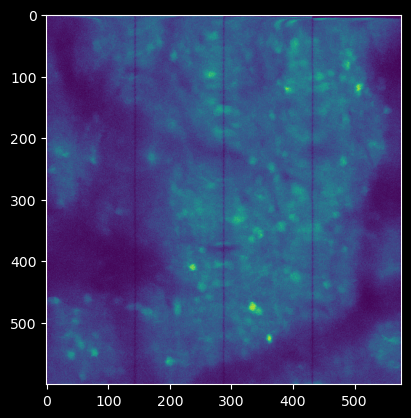

In [5]:
# full image, no scan phase correction, no ROI trimming

plt.imshow(scan[2,0,:,:].squeeze())
plt.show()

### First, without correcting for bi-directional scan phase

DEBUG:scanreader.scans:y_list: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215

Roi data loaded in 0.00397944450378418 seconds


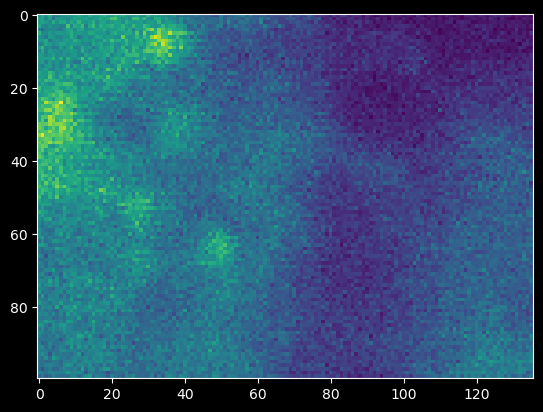

In [6]:
scan.trim_x = (5,5)
scan.trim_y = (17, 0)

plt.imshow(scan[2,0,400:600,300:400].squeeze())
plt.show()

### Next, with bi-directional scan phase correction

DEBUG:scanreader.scans:y_list: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215

Roi data loaded in 0.04904770851135254 seconds


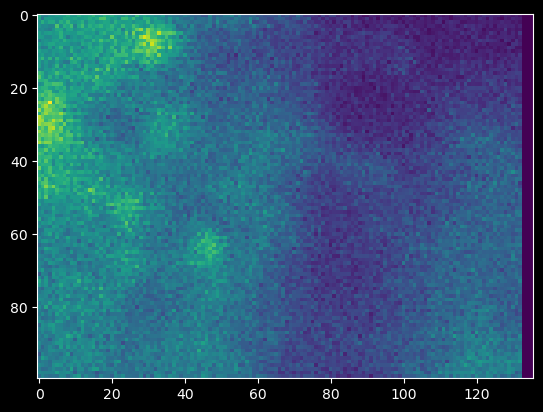

In [7]:
scan.fix_scan_offset = True

plt.imshow(scan[2,0,400:600,300:400].squeeze())
plt.show()

the `scanreader.data` property will show you the size and chunkshape of the current state of the scanreader:

In [8]:
scan.data

dask.array<empty_like, shape=(1730, 600, 576), dtype=float64, chunksize=(48, 600, 576), chunktype=numpy.ndarray>

## Preview final output before starting the pre-processing routine.

1. napari (recommended)
2. matplotlib
3. save to file (helpful for batch analysis)

## option 1: napari

Importing [napari-lbm](https://github.com/MillerBrainObservatory/napari-lbm/) exposes a GUI.

``` bash
pip install git+https://github.com/MillerBrainObservatory/napari-lbm.git
```

In [9]:
viewer = napari.Viewer()

viewer.window.add_plugin_dock_widget("napari-lbm", "LBMWidget")

(<napari._qt.widgets.qt_viewer_dock_widget.QtViewerDockWidget(0x5651be0ba900, name="LBMWidget (napari-lbm)") at 0x7f4d57b5f540>,
 <napari_lbm._widget.LBMWidget(0x5651be023be0) at 0x7f4d57bab980>)

### napari-lbm

The first time you load napari, there is an initialization process that takes roughly 30 seconds. Loading the napari-lbm plugin adds an additional 2-3 seconds when it is added as a dock widget.


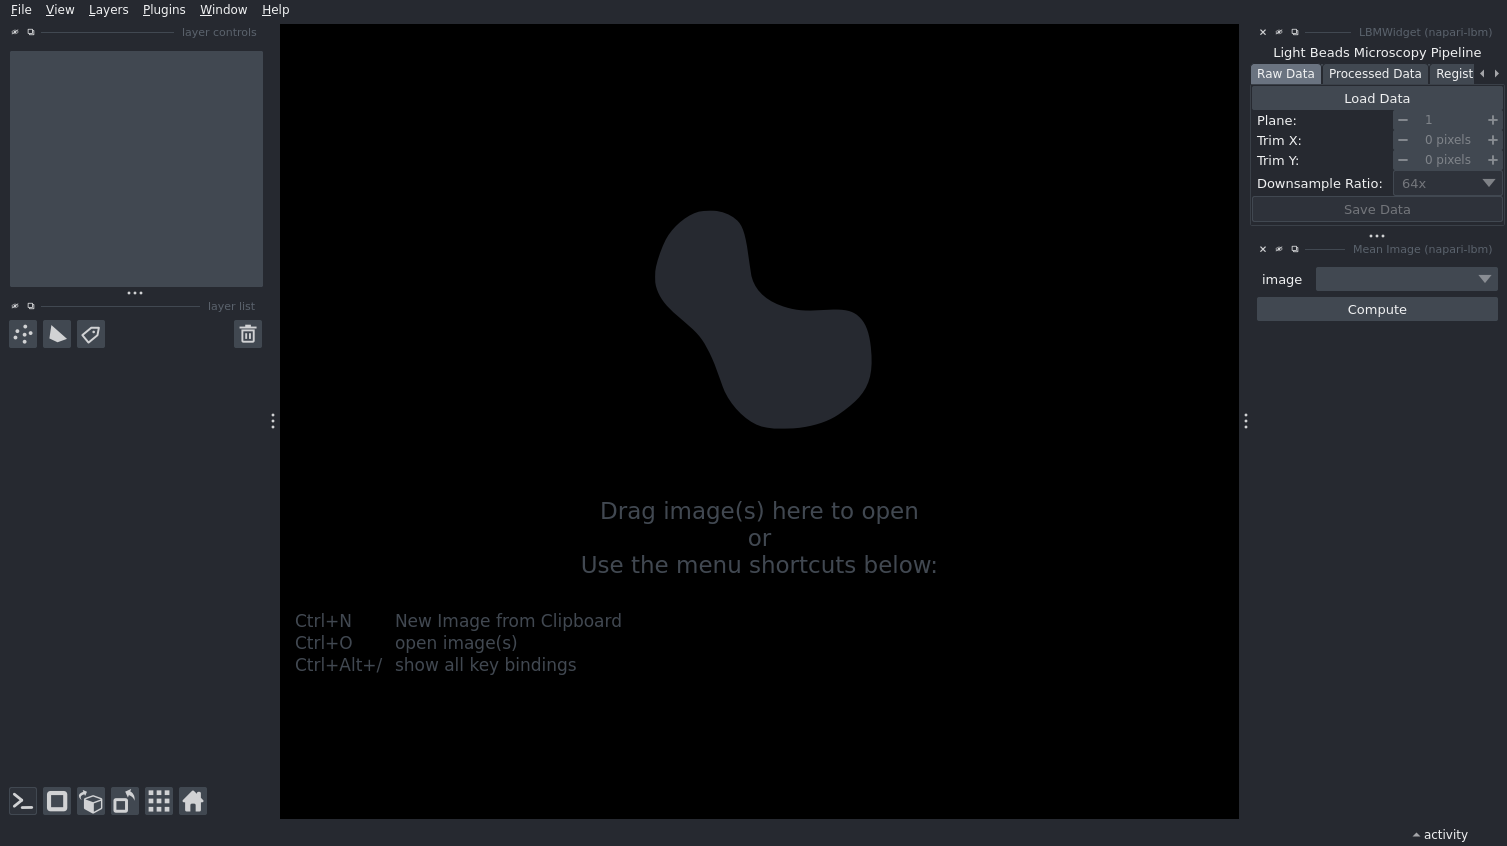

In [3]:
napari.utils.nbscreenshot(viewer)


Raw data tab
`Load Data` -> select a raw scanimage tiff file

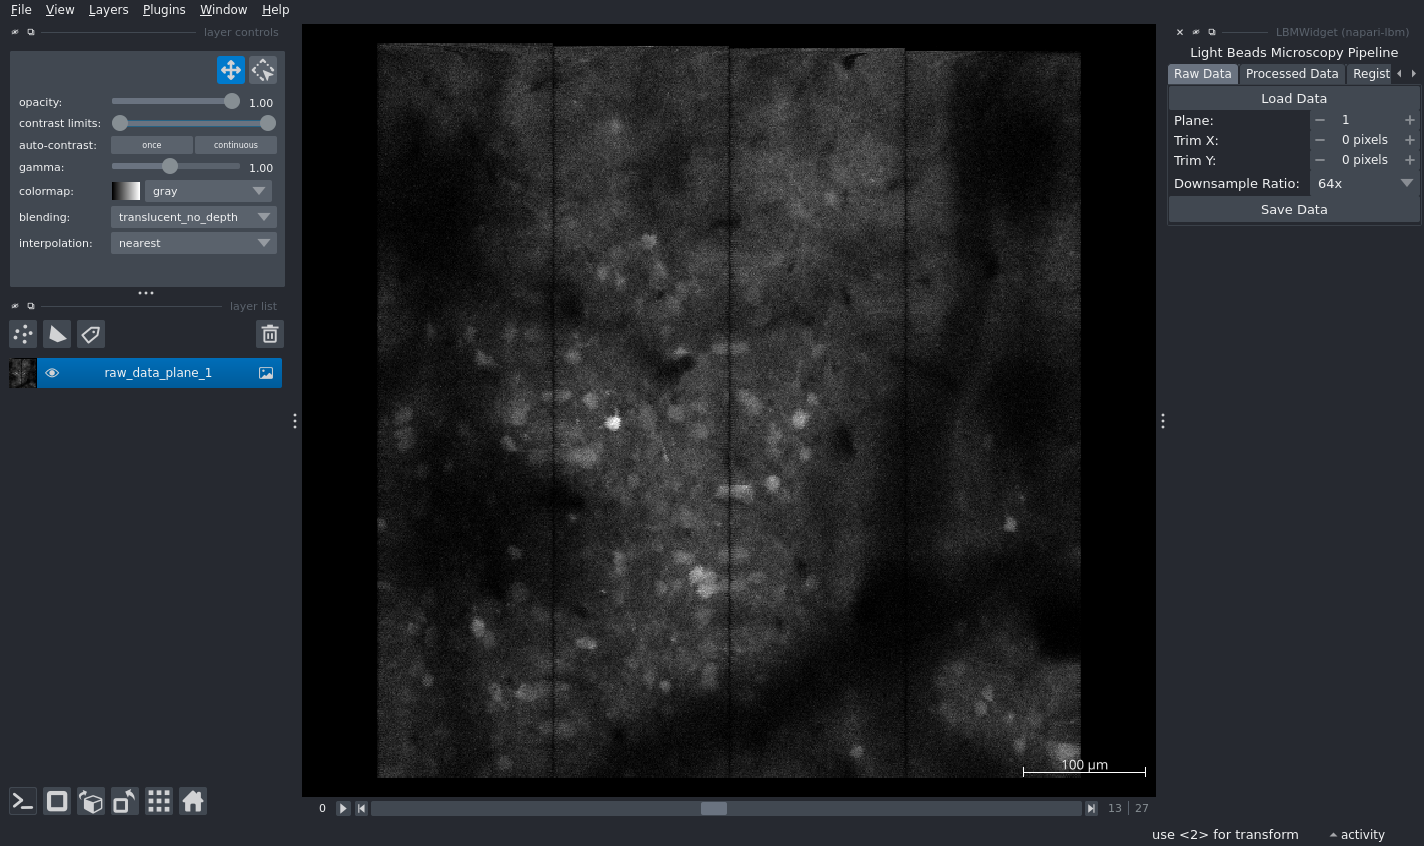

In [8]:
napari.utils.nbscreenshot(viewer)

In [10]:
viewer.close()

## option 2: matplotlib

WIP

# Save the result

- zarr (recommended)
- tiff (WIP)

In [47]:
# TIFF

sframes = (2, 802)
nframes = sframes[-1] - sframes[0]

savedir = parent_dir / 'final'
savedir.mkdir(exist_ok=True)
for idx, num in enumerate(range(1, scan.num_channels + 1)):
    filename = savedir / f'extracted_plane_{num}.tif'
    if idx in [0, 1]:
        plane = reader[2:802, idx, :,:]
        tifffile.imwrite(filename, plane, ome=True, bigtiff=True, metadata={'fps': scan.fps, 'photometric': 'minisblack'})

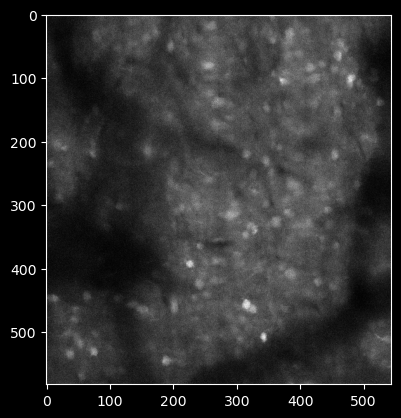

In [50]:
# To ensure the data was saved properly, load and display a single frame
start = time.time()
test_data = tifffile.imread(savedir / 'extracted_plane_1.tif')
print(time.time() - start)

plt.imshow(test_data[0, ...], cmap='gray')
plt.show()

## Saving Data Storage Options: Tiff, Zarr, HDF5

Zarr is the recommended datatype for this repository.

[Zarr documentation](https://zarr.readthedocs.io/en/stable/tutorial.html)

Deciding how to save data on a host operating system is far from straight foreward.
Read/write operations will vary widely between data saved in a **single file**
structure vs smaller chunks, e.g. one image per file, one image per epoch, etc. 
 
The former strategy is clean/consice and easy to handle but is *not* feasable with large (>10GB) datasets. 

- Zarr, similar to H5, is a heirarchical data storage specification.
- Zarr nicely hides the complexities inherent in linking filesystem heirarchy with efficient data I/O.

```python
name = '/path/to/folder'
chunksize=[300,300,1,1]
z1 = zarr.open(f'{name}', mode='w', shape=(data.shape),chunks=chunksize, dtype='int16')
```

In [25]:
save_path = parent_dir / 'results'

# planes_to_save=[2,15,16,28]
# lcp.save_as_zarr(scan, save_path, planes=planes_to_save)

In [24]:
import zarr

saved_data = zarr.open(save_path) # type: ignore  # zarr accepts pathlib.Path obj
saved_data.info

In [22]:
saved_data['plane_1'].info

Name,/plane_1
Type,zarr.core.Array
Data type,float64
Shape,"(3, 566, 526)"
Chunk shape,"(3, 566, 526)"
Order,C
Read-only,False
Compressor,"Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)"
Store type,zarr.storage.DirectoryStore
No. bytes,7145184 (6.8M)
No. bytes stored,1813968 (1.7M)


In [21]:
napari.view_image(saved_data['plane_1'])

Viewer(camera=Camera(center=(0.0, 282.5, 262.5), zoom=1.392490494296578, angles=(0.0, 0.0, 90.0), perspective=0.0, mouse_pan=True, mouse_zoom=True), cursor=Cursor(position=(1.0, 1.0, 0.0), scaled=True, style=<CursorStyle.STANDARD: 'standard'>, size=1.0), dims=Dims(ndim=3, ndisplay=2, order=(0, 1, 2), axis_labels=('0', '1', '2'), rollable=(True, True, True), range=(RangeTuple(start=0.0, stop=2.0, step=1.0), RangeTuple(start=0.0, stop=565.0, step=1.0), RangeTuple(start=0.0, stop=525.0, step=1.0)), margin_left=(0.0, 0.0, 0.0), margin_right=(0.0, 0.0, 0.0), point=(1.0, 282.0, 262.0), last_used=0), grid=GridCanvas(stride=1, shape=(-1, -1), enabled=False), layers=[<Image layer 'Image' at 0x7f4b60a94990>], help='use <2> for transform', status='Ready', tooltip=Tooltip(visible=False, text=''), theme='dark', title='napari', mouse_over_canvas=False, mouse_move_callbacks=[], mouse_drag_callbacks=[], mouse_double_click_callbacks=[], mouse_wheel_callbacks=[<function dims_scroll at 0x7f4b6da94360>], 

In [24]:
try:
    viewer.close()
except RuntimeError:
    print('Viewer already closed')

Viewer already closed


In [26]:
save_path = parent_dir / 'results'
zarr.open(save_path).info

Name,/
Type,zarr.hierarchy.Group
Read-only,False
Store type,zarr.storage.DirectoryStore
No. members,0
No. arrays,0
No. groups,0


In [31]:
napari.view_image(zarr.open(save_path)['plane_1'])

Viewer(camera=Camera(center=(0.0, 299.5, 279.5), zoom=1.3079464285714284, angles=(0.0, 0.0, 90.0), perspective=0.0, mouse_pan=True, mouse_zoom=True), cursor=Cursor(position=(864.0, 1.0, 0.0), scaled=True, style=<CursorStyle.STANDARD: 'standard'>, size=1.0), dims=Dims(ndim=3, ndisplay=2, order=(0, 1, 2), axis_labels=('0', '1', '2'), rollable=(True, True, True), range=(RangeTuple(start=0.0, stop=1729.0, step=1.0), RangeTuple(start=0.0, stop=599.0, step=1.0), RangeTuple(start=0.0, stop=559.0, step=1.0)), margin_left=(0.0, 0.0, 0.0), margin_right=(0.0, 0.0, 0.0), point=(864.0, 299.0, 279.0), last_used=0), grid=GridCanvas(stride=1, shape=(-1, -1), enabled=False), layers=[<Image layer 'Image' at 0x7f4b4efaf1d0>], help='use <2> for transform', status='Ready', tooltip=Tooltip(visible=False, text=''), theme='dark', title='napari', mouse_over_canvas=False, mouse_move_callbacks=[], mouse_drag_callbacks=[], mouse_double_click_callbacks=[], mouse_wheel_callbacks=[<function dims_scroll at 0x7f4b6da9